### Importing Required Libraries

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

### Pipeline

1. Computing the camera calibration matrix and distortion coefficients given a set of chessboard images to            undistort raw images.
2. Using HLS colour transform and Sobelx gradient finding filter to create a thresholded binary image.
3. Applying perspective transform to have a birds eye view for lane finding.
4. Detecting lane pixels and fiting a line to find the lane boundary.
5. Determinig the curvature of the lane and vehicle position with respect to center.
6. Warping the detected lane boundaries back onto the original image.
7. Visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Functions

1. Calibrating camera with chessboard images to find calibration matrix and distortion coefficients which are used to undistort raw images

In [2]:
def calibrateCam(image): # enter a pic which needs to be undistorted
    
    path = 'camera_cal'
    images = os.listdir(path)
    
    obj_pts = []
    img_pts = []

    obj_pts_gen = np.zeros((9*6, 3), np.float32)
    obj_pts_gen[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for img in images:
        cal_img = mpimg.imread(path + '/' + img)

        gray = cv.cvtColor(cal_img, cv.COLOR_RGB2GRAY)

        ret, corners = cv.findChessboardCorners(gray, (9,6), None)

        if ret==True:
            img_pts.append(corners)
            obj_pts.append(obj_pts_gen)

            cal_img = cv.drawChessboardCorners(cal_img, (9,6), corners, ret)
            

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(obj_pts, img_pts, gray.shape[::-1], None, None)

    dst = cv.undistort(image, mtx, dist, None, mtx)
    
#     f, ax = plt.subplots(1, 2, figsize = (40,20)) 
#     ax[0].imshow(image)
#     ax[0].set_title('Original Image (Distorted)', fontsize=50)
#     ax[1].imshow(dst)
#     ax[1].set_title('Undistorted Image', fontsize = 50)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return dst

2. Using HLS Colour Space and Sobel Gradient Computation to isolate lane lines in all lighting conditions and create a binary thresholded image with undistortion

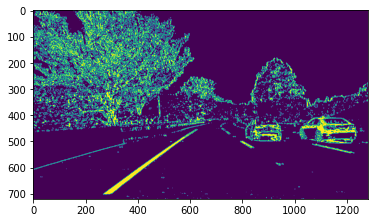

In [3]:
def colorGradientThreshold(frame):
       
    undist = calibrateCam(frame)  

    hls = cv.cvtColor(undist, cv.COLOR_RGB2HLS)
    gray = cv.cvtColor(undist, cv.COLOR_RGB2GRAY)

    S = hls[:,:,2]

    sat_min = 160
    sat_max = 255
    sat_binary = np.zeros_like(S)
    sat_binary[(S > sat_min) & (S <= sat_max)] = 1

    abs_sobelx = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0))
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    thresh_min = 20
    thresh_max = 100
    sob_binary = np.zeros_like(scaled_sobel)
    sob_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    color_binary = np.dstack(( np.zeros_like(sob_binary), sob_binary, sat_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sob_binary)
    combined_binary[(sat_binary == 1) | (sob_binary == 1)] = 1


    #f, ax = plt.subplots(1, 2, figsize = (15,10)) 
    #ax[0].imshow(undist)
    #ax[0].set_title('Original Image', fontsize=25)
    #ax[1].imshow(color_binary, cmap='gray')
    #ax[1].set_title('Combined Threshold', fontsize = 25)
    #ax[1,1].imshow(combined_binary, cmap='gray')
    #ax[1,1].set_title('Canny Edge', fontsize = 25)

    return combined_binary, undist

path = 'test_images'
    
img = mpimg.imread(path + '/' + 'test6.jpg') 
combined_binary, undist = colorGradientThreshold(img)
plt.imshow(combined_binary)


3. Perpective Transform for a birds eye view at the lanes to easily find radius of curvature.

In [4]:
def perspectiveTransform(combined_binary): 
    
    vertices = [(170, 719), (620,460), (730,460), (1120,719)]
    src = np.float32(vertices)

    offset = 300
    img_size = combined_binary.shape
    dst = np.float32([(offset,0), (offset, img_size[0]), (img_size[1]-offset,img_size[0]), (img_size[1]-offset,0)])
    
    ver = np.array(([vertices]), np.int32)
    #cv.polylines(undist, ver, True, (0,0,255), thickness=3)
    Mat = cv.getPerspectiveTransform(src, dst)
    Minv = cv.getPerspectiveTransform(dst, src)
    warped_binary = cv.warpPerspective(combined_binary, Mat, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv.INTER_LINEAR)
    
    #f, ax = plt.subplots(1, 2), figsize = (15,10)) 
    #ax[0].imshow(warped_binary, cmap='gray')
    #ax[0].set_title('Warped', fontsize = 25)
    #ax[1].imshow(undist, cmap='gray')
    #ax[1].set_title('ROI', fontsize = 25)

    return warped_binary, Minv

warped_binary, Minv = perspectiveTransform(combined_binary)

4. Using Histogram to find maximum pixel concentration area to start line fitting

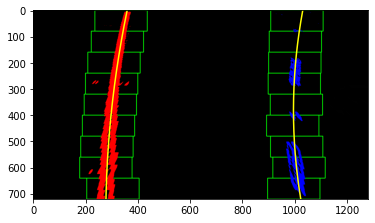

In [5]:
def slideWindow(warped_binary):

    histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped_binary.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin # try and change this
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        #print(good_left_inds)
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(warped_binary):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = slideWindow(warped_binary)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, ploty


out_img, left_fit, right_fit, ploty = fit_polynomial(warped_binary)

plt.imshow(out_img)


5. Using previous polynomial fitting value to find lane pixel instead of blind search

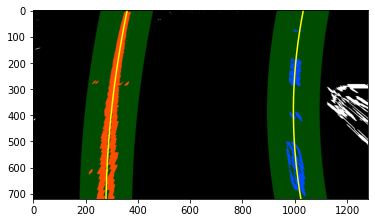

In [6]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(warped_binary, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    
    margin = 100

    # Grab activated pixels
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped_binary.shape, leftx, lefty, rightx, righty)
    #print(ploty)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, ploty = search_around_poly(warped_binary, left_fit, right_fit)
#print(left_fitx)
# View your output
plt.imshow(result)

def warpBack(warped_binary, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    unwarped = cv.addWeighted(undist, 1, newwarp, 0.3, 0)

    #f, ax = plt.subplots(1, 1, figsize = (15,10)) 
    #ax.imshow(unwarped)
    #ax.set_title('Unwarped', fontsize = 25)
    #ax[1].imshow(unwarped)
    #ax[1].set_title('Unwarped', fontsize = 25)
    #plt.imshow(unwarped)
    
    return unwarped
unwarped = warpBack(warped_binary, left_fitx, right_fitx, ploty)

6. Calculating Radius of Curvature and Car's postion with respect to the middle of the lane.

1264.0724484388945 89.37756720795119


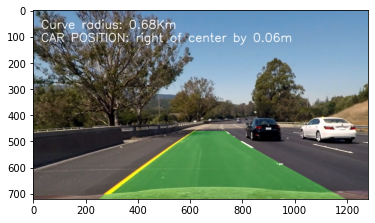

In [7]:
def fit_polynomial_cr(warped_binary,ym_per_pix, xm_per_pix):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = slideWindow(warped_binary)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*ym_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


    return left_fit_cr, right_fit_cr, ploty

def measure_curvature_pixels(warped_binary):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr, right_fit_cr, ploty = fit_polynomial_cr(warped_binary, ym_per_pix, xm_per_pix)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curve_rad = (left_curverad + right_curverad)/2
    return left_curverad, right_curverad, curve_rad

def carPosition(unwarped, left_fit, right_fit):
    height = unwarped.shape[0]
    car_middle = unwarped.shape[1]/2
    left_fitx = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    right_fitx = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    
    lane_centerx = (left_fitx+right_fitx)/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    car_position = (abs(lane_centerx-car_middle))*xm_per_pix
    
    if car_position>0:
        pos_text = "right of center by " + '{:03.2f}'.format(car_position)
    else:
        pos_text = "left of center by " + '{:03.2f}'.format(car_position)
    return pos_text    
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad, curve_rad= measure_curvature_pixels(warped_binary)

pos_text = carPosition(unwarped, left_fit, right_fit)

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

def display(unwarped, curve_rad, pos_text):
    font = cv.FONT_HERSHEY_SIMPLEX
    rad_text = 'Curve radius: ' + '{:02.2f}'.format(curve_rad/1000) + 'Km'
    
    cv.putText(unwarped, rad_text, (30,70), font, 1.5, (255,255,255), 2, cv.LINE_AA)
    
    position_text = "CAR POSITION: " + pos_text + 'm'
    cv.putText(unwarped, position_text, (30,120), font, 1.5, (255,255,255), 2, cv.LINE_AA)
    #print(position_text)
    return unwarped

final = display(unwarped, curve_rad, pos_text)
plt.imshow(final)
    

In [8]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

7. A pipeline for the Videos

In [9]:
vid = cv.VideoCapture('project_video.mp4')
frame_width = int(vid.get(3))
frame_height = int(vid.get(4))
#out = cv.VideoWriter('test_video_output/project_video_output.mp4', cv.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

In [18]:
vid = cv.VideoCapture('challenge_video.mp4')
frame_width = int(vid.get(3))
frame_height = int(vid.get(4))
#out = cv.VideoWriter('test_video_output/project_video_output.mp4', cv.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

In [11]:
vid = cv.VideoCapture('harder_challenge_video.mp4')
frame_width = int(vid.get(3))
frame_height = int(vid.get(4))
out = cv.VideoWriter('test_video_output/project_video_output.mp4', cv.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

In [19]:
while vid.isOpened():
    
    ret, frame = vid.read()
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    if ret==True:
        combined_binary, undist = colorGradientThreshold(frame)
        

#         warped_binary, Minv = perspectiveTransform(combined_binary)

#         out_img, left_fit, right_fit, ploty = fit_polynomial(warped_binary)

#         result, left_fitx, right_fitx, ploty = search_around_poly(warped_binary, left_fit, right_fit)

#         unwarped = warpBack(warped_binary, left_fitx, right_fitx, ploty)

#         left_curverad, right_curverad, curve_rad = measure_curvature_pixels(warped_binary)

#         pos_text = carPosition(unwarped, left_fit, right_fit)

#         final = display(unwarped, curve_rad, pos_text)
        
        #cv.imshow('final', final)
        #plt.imshow(combined_binary)
        cv.imshow('Combined Binary', combined_binary)
        key = cv.waitKey(25)

        if key == 32:
            cv.waitKey()
        elif key == ord('q'):
            break
    else:
        break
            
vid.release()
cv.destroyAllWindows()